In [8]:
import sys
import itertools

import numpy as np
import pandas as pd
import scipy.signal
from tqdm import tqdm

import neuroseries as nts


import time
import matplotlib.pyplot as plt

import seaborn as sns 
import bk.load
import bk.compute
import bk.plot
import bk.signal
import bk.stats

import os

import sklearn.cluster

In [2]:
%matplotlib qt

In [3]:
bk.load.current_session_linux('/mnt/electrophy/Billel/BK-Dataset/ePhys/','Rat95/Rat95-20220418')
# Load LFP and acc
lfp = bk.load.lfp(20)
acc = bk.load.lfp(98)
# Transforme acc in motion

In [4]:
bk.load.current_session_linux()
lfp = bk.load.lfp(23)

Rat : 8 on day : 6
Working with session Rat08-20130713 @ /mnt/electrophy/Gabrielle/GG-Dataset-Light/Rat08/Rat08-20130713


In [1]:
from imports import * 

In [2]:
bk.load.current_session_linux('/media/billel/DATA/BK-DATA/','Rat95/Rat95-20220418')
# Load LFP and acc
lfp = bk.load.lfp(20)
# Transforme acc in motion

Rat : 95 on day : 10
Working with session Rat95-20220418 @ /media/billel/DATA/BK-DATA/Rat95/Rat95-20220418


In [3]:
f, t, Sxx = scipy.signal.spectrogram(lfp.values,1250,nperseg=5000,noverlap=4000)
delta = (0.1<f) & (f<4)
theta = (6<f) & (f<8)
gamma = (40<f) & (f<100)


delta_average = np.mean(np.log(Sxx[delta,:]),axis = 0)
theta_average = np.mean(np.log(Sxx[theta,:]),axis = 0)
gamma_average = np.mean(np.log(Sxx[gamma,:]),axis = 0)

del lfp

In [4]:
acc = bk.load.lfp(98)
motion = np.abs(np.diff(acc.values))
motion = scipy.signal.resample(motion,len(t))
motion = bk.compute.smooth(motion,1250,2)

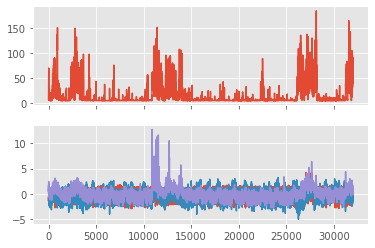

In [5]:
fig,ax = plt.subplots(2,1,sharex = True)
ax[0].plot(motion)
ax[1].plot(scipy.stats.zscore(delta_average))
ax[1].plot(scipy.stats.zscore(theta_average))
ax[1].plot(scipy.stats.zscore(gamma_average))

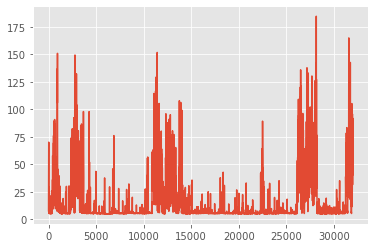

In [6]:
plt.plot(motion)

In [6]:
th = 25
time_immo = 0
wake = motion > th
wake_inter = bk.compute.toIntervals(t,wake,'s')
wake_inter = wake_inter.drop_short_intervals(3,'s').reset_index(drop = True)
wake_inter.end = wake_inter.end + 30_000_000
wake_inter = wake_inter.merge_close_intervals(30,'s')

sleep = np.isnan(wake_inter.in_interval(nts.Ts(t,'s')))

record_inter = nts.IntervalSet(np.min(acc.times()),np.max(acc.times())) 
sleep_inter = record_inter.set_diff(wake_inter)
# sleep = motion < th
# sleep_inter = bk.compute.toIntervals(t,sleep,'s').drop_short_intervals(time_immo,'s').reset_index(drop = True)
# plt.plot(t,motion)
# plt.axhline(th,color = 'r')

# bk.plot.intervals(sleep_inter,'grey')
# bk.plot.intervals(wake_inter,'red')


# plt.xlabel('Times (s)')
# plt.ylabel('Motion (diff of acc)')
# plt.legend(['Motion','Motion Treshold','Sleep','Wake',])


In [9]:
# X = np.vstack((delta_average[sleep],theta_average[sleep],gamma_average[sleep])).T
X = np.vstack((delta_average[sleep],theta_average[sleep],gamma_average[sleep])).T
k = sklearn.cluster.k_means(X,2,n_init=100)
theta_in_cluster = []
for i in np.unique(k[1]):
    theta_in_cluster.append(np.mean(theta_average[sleep][k[1] == i]))
REM_cluster = np.argsort(theta_in_cluster)[-1]

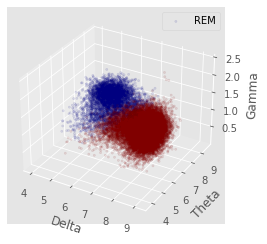

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2],c = k[1],s = 5,alpha = 0.1,cmap = 'jet')
ax.set_xlabel('Delta')
ax.set_ylabel('Theta')
ax.set_zlabel('Gamma')
plt.legend(['REM','NREM'])

# Assign labels to whole recordings

In [12]:
labels = np.zeros(len(t),dtype = 'object')-1
labels[sleep] = k[1]
labels[labels != REM_cluster] = 'NREM'
labels[labels == REM_cluster] = 'REM'
labels[~sleep] = 'WAKE'

states = {}
for state in np.unique(labels):
    states.update({state:bk.compute.toIntervals(t,labels == state,'s')})#.merge_close_intervals(5,'s')})

In [21]:
for state in np.unique(labels):
    states[state]['state'] = state

In [24]:
pd.concat(states).to_csv('sleep_scoring.csv')

In [28]:
dSxx,dt = scipy.signal.resample(Sxx,1250,t,axis = 1)
fig,ax = plt.subplots(3,1,True)
ax[0].pcolor(dt,f,np.log(dSxx),vmin = 0,vmax = 12,rasterized = True)
ax[0].set_ylim(0,50)
# ax[1].plot(lfp.as_units('s'))
plt.sca(ax[1])
bk.plot.intervals(states['WAKE'],'green')
bk.plot.intervals(states['REM'])
bk.plot.intervals(states['NREM'],'grey')
ax[2].plot(acc.as_units('s'))

/tmp/ipykernel_120969/881529831.py:2: MatplotlibDeprecationWarning: Passing the sharex parameter of subplots() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  fig,ax = plt.subplots(3,1,True)
/tmp/ipykernel_120969/881529831.py:3: RuntimeWarning: invalid value encountered in log
  ax[0].pcolor(dt,f,np.log(dSxx),vmin = 0,vmax = 12,rasterized = True)
/tmp/ipykernel_120969/881529831.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolor(dt,f,np.log(dSxx),vmin = 0,vmax = 12,rasterized = True)
